In [51]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy

import tensorNets.a_mps as a_mps
import tensorNets.d_dmrg as d_dmrg

from heisenbergModel import HeisenbergModel, HeisenbergModelNearestNeighbors, HeisenbergModelNoDecay

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The Heisenberg model is build in `HeisenbergModel.py`. We only want to perform DMRG, so the only relevant function is `generate_H_mpo()`

rewrite Hamiltonian:
$$
H = J \sum_{i<j} \lambda ^{j-i} \sum_{\alpha = x,y,z} S_i^\alpha S_j^\alpha \qquad \lambda = e ^{-\frac{1}{\xi}}
$$

In [52]:
# hyperparameters
L = 10  # system size
J = 1.0  # coupling strength
XI = 1.0  # correlation length

In [53]:
def init_spindown_MPS(L):
    """Return a product state with all spins up as an MPS"""
    B = np.zeros([1, 2, 1], np.float64)
    B[0, 0, 0] = -1.
    S = np.ones([1], np.float64)
    Bs = [B.copy() for i in range(L)]
    Ss = [S.copy() for i in range(L)]
    return a_mps.MPS(Bs, Ss)

In [54]:
model, mps, engine = run_dmrg_simulation(10, J, XI, tol=1e-10)

Energy: 2.176764829510825
Energy: -3.4195035675868413
Energy: -3.4352868503079876
Energy: -3.4352892374375745
Energy: -3.435289237437584
The system is converged after 5 sweeps!


In [58]:
model.Sz @ model.Sz

array([[0.25, 0.  ],
       [0.  , 0.25]])

In [55]:
engine.calc_e_2()

array(-6.87057847)

In [56]:
engine.calculate_energy()

array(-3.43528924)

In [ ]:
# function to run the DMRG algorithm

def run_dmrg_simulation(L, J, xi, max_sweeps=20, tol=1e-9, chi_max=100):
    mps = a_mps.init_spinup_MPS(L)
    model = HeisenbergModel(L, J, xi)
    engine = d_dmrg.DMRGEngine(mps, model, chi_max=chi_max)

    # E_exact = tfi_exact.finite_gs_energy(L, J, g)

    E, E_prev = 0, 0

    for i in range(max_sweeps):
        engine.sweep()
        E_prev = E
        E = engine.calculate_energy()
        print("Energy:", E)
        # print("Energy error:", E - E_exact)
        if np.abs(E - E_prev) < tol:
            print(f"The system is converged after {i+1} sweeps!")
            break
    
    return model, mps, engine

In [8]:
model, mps, engine = run_dmrg_simulation(24, J, XI, tol=1e-10)

Energy: -8.916907090342445
Energy: -8.96464826734617
Energy: -8.964964767964279
Energy: -8.964964770428686
Energy: -8.964964770428637
The system is converged after 5 sweeps!


## Influence of $\xi$ on the Correlations

Do the same as in the problem sheet about DMRG. i is L/4 and calculate correlations for every $j > i$. then plot the correlations for different $\xi$ values.

In [ ]:
def calculate_two_operator_expectation(psi, X, Y, i):
    """
    Calculate the expectation value of two operators on the MPS.
    <psi|X_i X_j|psi>
    where |psi> is the MPS.

    calculate for all j >= i
    
    """
    return_list = []

    # first calculate the left hand structure. its always the same so we can precompute and update it.
    theta_i = psi.get_theta1(i) 
    X_theta_i = np.tensordot(X, theta_i, axes=[1, 1])  # i [i*], vL [i] vR
    left_exp_struct = np.tensordot(theta_i.conj(), X_theta_i, [[0, 1], [1, 0]]) # [vL*] [i*] vR*, [i] [vL] vR

    for j in range(i, psi.L):
        if j == i:
            op  = np.tensordot(X, Y, [1, 0]) # i [i*], [i] i*
            op_theta = np.tensordot(op, theta_i, axes=[1, 1])  # i [i*], vL [i] vR
            exp_val = np.tensordot(theta_i.conj(), op_theta, [[0, 1, 2], [1, 0, 2]]) # [vL*] [i*] [vR*], [i] [vL] [vR]
            return_list.append(exp_val)
        else:
            tmp = np.tensordot(Y, psi.Bs[j], axes=[1,1]) # i [i*], vL [i] vR
            right_side = np.tensordot(psi.Bs[j].conj(), tmp, axes=[[1,2],[0,2]])  # vL* [i*] [vR*], [i] vL [vR]
            exp_val = np.tensordot(left_exp_struct, right_side, [[0, 1], [0, 1]]) # [vR*] [vR], [vL*] [vL]
            return_list.append(exp_val)
            # update the left structure
            left_exp_struct = np.tensordot(left_exp_struct, psi.Bs[j], axes=[1,0]) # vR* [vR] x [vL], i, vR
            left_exp_struct = np.tensordot(left_exp_struct, psi.Bs[j].conj(), axes=[[1,0],[1,0]]) # [vR*] [i] vR x [vL*] [i*] vR*
            left_exp_struct = np.transpose(left_exp_struct, (1,0)) # vR* vR

    return np.array(return_list)

# e)
def correlation_function(psi, X, Y, i):
    L = psi.L
    assert i < L
    corrs = []
    # first case: j = i
    # Note: psi.get_theta(i) = Lambda[i] B[i] with axes vL i vR
    theta = psi.get_theta1(i)  # vL i vR
    X_Y_theta = np.tensordot(np.dot(X, Y), # i [i*], [i] i*
                             theta, axes=([1], [1]))  # i [i*], vL [i] vR
    contr = np.tensordot(theta.conj(), X_Y_theta, axes=([0, 1, 2], [1, 0, 2]))  # [vL*] [i*] [vR*], [i] [vL] [vR]
    corrs.append(contr)
    # now for i < j
    theta = psi.get_theta1(i)  # vL i vR
    LP = np.tensordot(X, theta, axes=([1], [1]))  # i [i*], vL [i] vR
    LP = np.tensordot(theta.conj(), LP, axes=([0, 1], [1, 0])) # [vL*] [i*] vR*, [i] [vL] vR
    # now LP has axes vR*, vR
    for j in range(i+1, L):
        # contract with B Y B* to evalluate the correlation function for given j
        B = psi.Bs[j]  # vL j vR
        Y_B = np.tensordot(Y, B, axes=([1], [1])) # j [j*], vL [j] vR
        contr = np.tensordot(LP, Y_B, axes=([1], [1])) # vR* [vR], j [vL] vR
        contr = np.tensordot(contr, B.conj(), axes=([0, 1, 2], [0, 1, 2])) # [vR*] [j] [vR], [vL*] [j*] [vR*]
        corrs.append(contr.item())
        # get next LP for next i
        LP = np.tensordot(LP, B, axes=([1], [0])) # vR* [vR], [vL] j vR
        LP = np.tensordot(B.conj(), LP, axes=([0, 1], [0, 1])) # [vL*] [j*] vR*, [vR*] [j] vR
    return np.real_if_close(corrs)


In [46]:
xi_range = [0.1, 1., 2.0, 5.0, 10., 20.0]
L_for_correlations = 32

ground_states = []
sigmax = np.array([[0., 1.], [1., 0.]])

for xi in xi_range:
    print(f"Running DMRG simulation for xi = {xi}")
    model, mps, engine = run_dmrg_simulation(L_for_correlations, J, xi, tol=1e-10)
    ground_states.append(mps)



Running DMRG simulation for xi = 0.1
Energy: -13.456713419475399
Energy: -13.559660906066199
Energy: -13.562188943004028
Energy: -13.562189131573206
Energy: -13.562189131573394
The system is converged after 5 sweeps!
Running DMRG simulation for xi = 1.0
Energy: -12.060057247551846
Energy: -12.124637105040549
Energy: -12.125451746465865
Energy: -12.12545178362476
Energy: -12.125451783624758
The system is converged after 5 sweeps!
Running DMRG simulation for xi = 2.0
Energy: -11.638548021545214
Energy: -11.662232409837424
Energy: -11.662374856160898
Energy: -11.662374877057509
Energy: -11.662374877057605
The system is converged after 5 sweeps!
Running DMRG simulation for xi = 5.0
Energy: -10.332342903917963
Energy: -11.115780353645174
Energy: -11.518959340265631
Energy: -11.518959362447733
Energy: -11.518959362447971
The system is converged after 5 sweeps!
Running DMRG simulation for xi = 10.0
Energy: -5.182393451591188
Energy: -11.267523144092998
Energy: -11.503812515822602
Energy: -11.

In [47]:
sigmaz = np.array([[1., 0.], [0., -1.]])
Sz = sigmaz
correlations = [calculate_two_operator_expectation(mps, Sz, Sz, L_for_correlations // 4) for mps in ground_states]
# correlations2 = [correlation_function(mps, Sz, Sz, L_for_correlations // 4) for mps in ground_states]

for reference, Heisenberg with only nearest neighbour interaction:

In [ ]:
# function to run the DMRG algorithm

def run_dmrg_simulation_only_NN(L, J, xi, max_sweeps=20, tol=1e-9):
    mps = a_mps.init_spinup_MPS(L)
    model = HeisenbergModelNearestNeighbors(L, J, xi)
    engine = d_dmrg.DMRGEngine(mps, model)

    # E_exact = tfi_exact.finite_gs_energy(L, J, g)

    E, E_prev = 0, 0

    for i in range(max_sweeps):
        engine.sweep()
        E_prev = E
        E = engine.calculate_energy()
        print("Energy:", E)
        # print("Energy error:", E - E_exact)
        if np.abs(E - E_prev) < tol:
            print(f"The system is converged after {i+1} sweeps!")
            break
    
    return model, mps, engine

modelNN, mpsNN, engineNN = run_dmrg_simulation_only_NN(L_for_correlations, J, XI, tol=1e-9)
correlations_NN = calculate_two_operator_expectation(mpsNN, sigmaz, sigmaz, L_for_correlations // 4)


In [16]:
def expected_correlation_function(distance, xi):
    """
    Calculate the expected correlation function for a given lattice size L and correlation length xi.
    """
    return np.exp(-distance / xi)

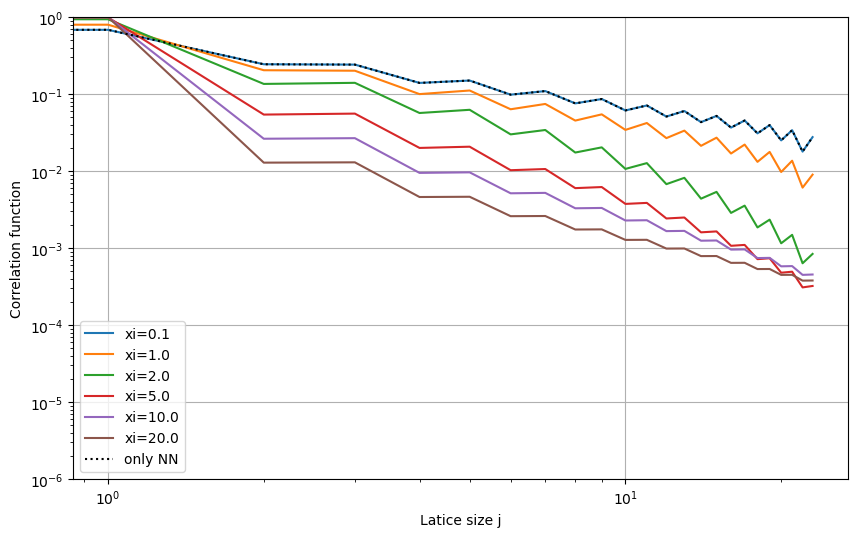

In [83]:
fig, ax = plt.subplots(figsize=(10, 6))

# L_plot = np.linspace(L_for_correlations // 4, L_for_correlations, len(correlations[0]))
L_plot = np.arange(0, len(correlations[0]))

ax.set_yscale('log')
ax.set_xscale('log')

for i, g in enumerate(xi_range):
    ax.plot(L_plot, np.abs(correlations[i].real), label=f'xi={g}', color=f'C{i}')
    # ax.plot(L_plot, expected_correlation_function(L_plot - L_for_correlations // 4, g), linestyle='--' ,color=f'C{i}', alpha=0.5)

ax.plot(L_plot, np.abs(correlations_NN.real), label='only NN', linestyle=':', color='black')

ax.set_xlabel("Latice size j")
ax.set_ylabel("Correlation function")

ax.set_ylim(1e-6, 1.0)

ax.legend()

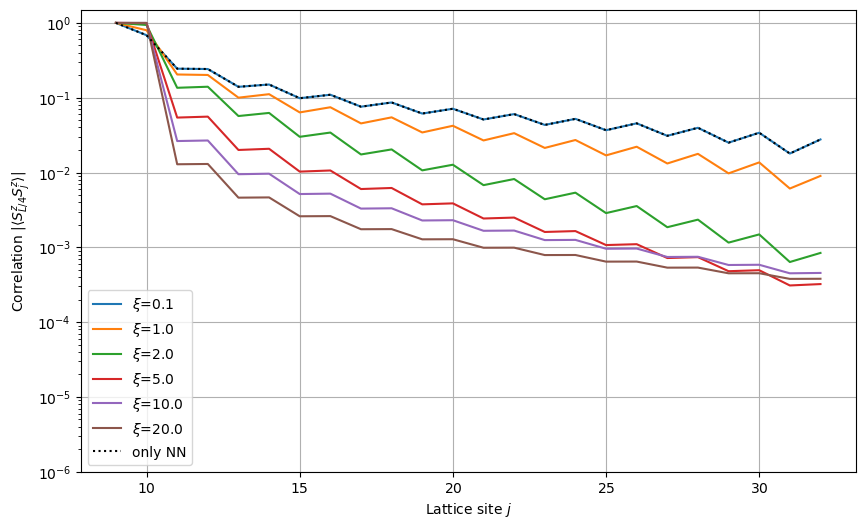

In [84]:
fig, ax = plt.subplots(figsize=(10, 6))

L_plot = np.linspace(L_for_correlations // 4 + 1, L_for_correlations, len(correlations[0]))

ax.set_yscale('log')

for i, g in enumerate(xi_range):
    ax.plot(L_plot, np.abs(correlations[i]), label=f'$\\xi$={g}', color=f'C{i}')
    # ax.plot(L_plot, expected_correlation_function(L_plot - L_for_correlations // 4, g), linestyle='--' ,color=f'C{i}', alpha=0.5)

ax.plot(L_plot, np.abs(correlations_NN.real), label='only NN', linestyle=':', color='black')

ax.set_xlabel("Lattice site $j$")
ax.set_ylabel("Correlation $|\\langle S^z_{L/4} S^z_j \\rangle|$")

ax.set_ylim(1e-6, 1.5)

ax.legend()

fig.savefig("plots/correlation_functions_abs_log.pdf", bbox_inches='tight')

/Users/timmguthle/miniforge3/envs/physics2/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/timmguthle/miniforge3/envs/physics2/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


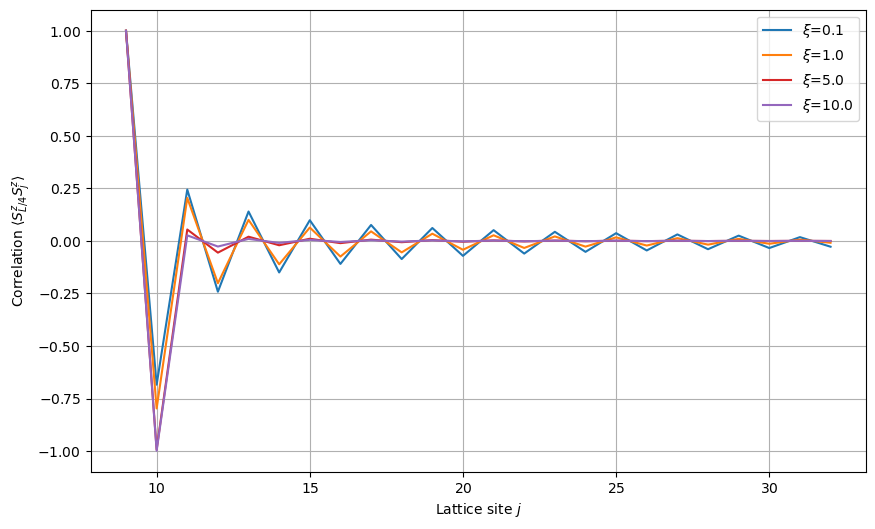

In [85]:
fig, ax = plt.subplots(figsize=(10, 6))

# L_plot = np.arange(1, len(correlations[0]) +1)
L_plot = np.linspace(L_for_correlations // 4 + 1, L_for_correlations, len(correlations[0]))


# ax.set_yscale('log')
# ax.set_xscale('log')

for i, g in enumerate(xi_range):
    if g in [2,20.0]:
        continue
    ax.plot(L_plot, correlations[i], label=f'$\\xi$={g}', color=f'C{i}')
    # ax.plot(L_plot, expected_correlation_function(L_plot - L_for_correlations // 4, g), linestyle='--' ,color=f'C{i}', alpha=0.5)

# ax.plot(L_plot, correlations_NN.real, label='only NN', linestyle=':', color='black')

ax.set_xlabel("Lattice site $j$")
ax.set_ylabel("Correlation $\\langle S^z_{L/4} S^z_j \\rangle$")

# ax.set_ylim(1e-6, 1.5)

ax.legend()
fig.savefig("plots/correlation_functions_simple.pdf", bbox_inches='tight')

In [86]:
xi_range = [0.1, 1., 2.0, 5.0, 10., 20.0]
L_for_correlations_2 = 64

ground_states_64 = []
sigmax = np.array([[0., 1.], [1., 0.]])

for xi in xi_range:
    print(f"Running DMRG simulation for xi = {xi}")
    model, mps, engine = run_dmrg_simulation(L_for_correlations_2, J, xi, tol=1e-10)
    ground_states_64.append(mps)



Running DMRG simulation for xi = 0.1
Energy: -27.551232971084083
Energy: -27.727927613480347
Energy: -27.740395415975094
Energy: -27.7404139555383
Energy: -27.7404139560101
Energy: -27.7404139560091
The system is converged after 6 sweeps!
Running DMRG simulation for xi = 1.0
Energy: -24.634607327624174
Energy: -24.765172014411142
Energy: -24.769462898578357
Energy: -24.769466123235393
Energy: -24.76946612337605
Energy: -24.769466123376006
The system is converged after 6 sweeps!
Running DMRG simulation for xi = 2.0
Energy: -23.514948061582558
Energy: -23.815363828937713
Energy: -23.81582691833447
Energy: -23.815827086535144
Energy: -23.81582708653939
The system is converged after 5 sweeps!
Running DMRG simulation for xi = 5.0
Energy: -19.388567831157783
Energy: -23.47499423128597
Energy: -23.533465198931115
Energy: -23.533465212735607
Energy: -23.533465212735827
The system is converged after 5 sweeps!
Running DMRG simulation for xi = 10.0
Energy: 2.6577317612132294
Energy: -21.985595556

In [87]:
correlations_64 = [calculate_two_operator_expectation(mps, Sz, Sz, L_for_correlations_2 // 4) for mps in ground_states_64]

In [91]:
np.save("ground_states_64.npy", ground_states_64)

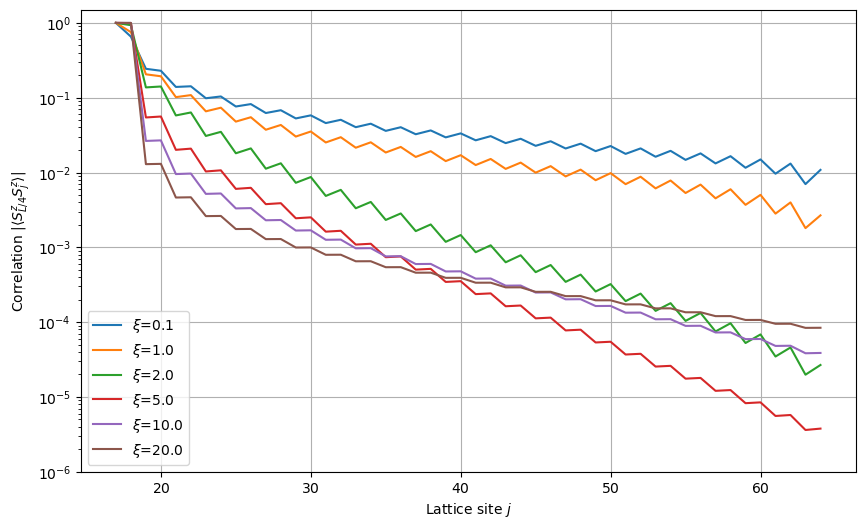

In [93]:
fig, ax = plt.subplots(figsize=(10, 6))

L_plot = np.linspace(L_for_correlations_2 // 4 + 1, L_for_correlations_2, len(correlations_64[0]))

ax.set_yscale('log')
# ax.set_xscale('log')

for i, g in enumerate(xi_range):
    ax.plot(L_plot, np.abs(correlations_64[i]), label=f'$\\xi$={g}', color=f'C{i}')
    # ax.plot(L_plot, expected_correlation_function(L_plot - L_for_correlations // 4, g), linestyle='--' ,color=f'C{i}', alpha=0.5)

# ax.plot(L_plot, np.abs(correlations_NN.real), label='only NN', linestyle=':', color='black')

ax.set_xlabel("Lattice site $j$")
ax.set_ylabel("Correlation $|\\langle S^z_{L/4} S^z_j \\rangle|$")

ax.set_ylim(1e-6, 1.5)

ax.legend()

fig.savefig("plots/correlation_functions_abs_log_64.pdf", bbox_inches='tight')

/Users/timmguthle/miniforge3/envs/physics2/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/timmguthle/miniforge3/envs/physics2/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


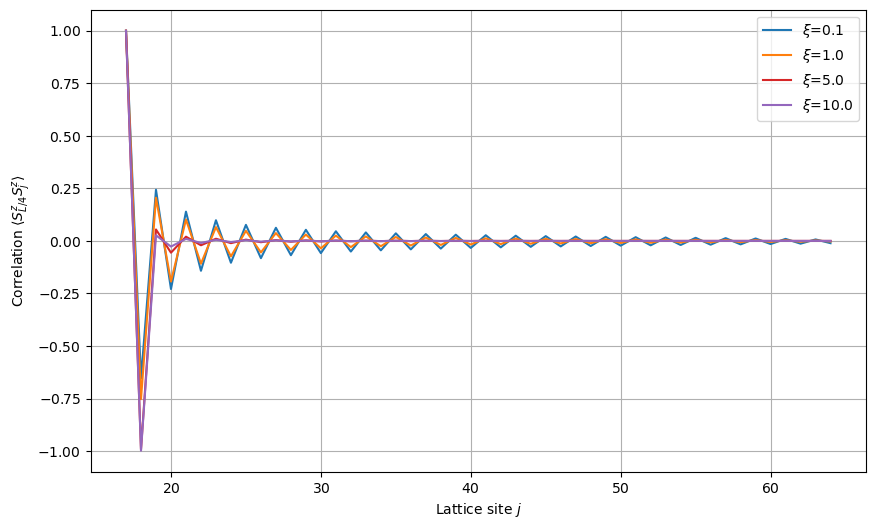

In [94]:
fig, ax = plt.subplots(figsize=(10, 6))

# L_plot = np.arange(1, len(correlations[0]) +1)
L_plot = np.linspace(L_for_correlations_2 // 4 + 1, L_for_correlations_2, len(correlations_64[0]))


# ax.set_yscale('log')
# ax.set_xscale('log')

for i, g in enumerate(xi_range):
    if g in [2,20.0]:
        continue
    ax.plot(L_plot, correlations_64[i], label=f'$\\xi$={g}', color=f'C{i}')
    # ax.plot(L_plot, expected_correlation_function(L_plot - L_for_correlations // 4, g), linestyle='--' ,color=f'C{i}', alpha=0.5)

# ax.plot(L_plot, correlations_NN.real, label='only NN', linestyle=':', color='black')

ax.set_xlabel("Lattice site $j$")
ax.set_ylabel("Correlation $\\langle S^z_{L/4} S^z_j \\rangle$")

# ax.set_ylim(1e-6, 1.5)

ax.legend()
fig.savefig("plots/correlation_functions_simple_64.pdf", bbox_inches='tight')

## order parameter of spin liquid phase

In [74]:
def order_parameter(psi:a_mps.MPS):
    """
    Calculate the order parameter of the spin liquid phase.
    """
    operator = np.kron(sigmaz, sigmaz).reshape((2, 2, 2, 2))  # operator for <S^z_j S^z_j+1>
    op_list = [operator.copy() for _ in range(psi.L)]
    exp_values = psi.bond_expectation_value(op_list)

    tmp = exp_values[:-1] - exp_values[1:]

    mask = np.tile([1,-1], psi.L // 2 - 1)
    return np.sum(tmp * mask)


OP = [order_parameter(mps) for mps in ground_states]

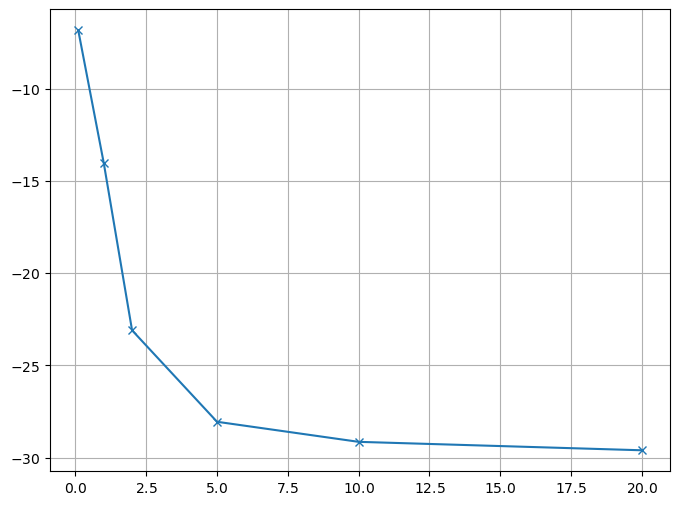

In [75]:

plt.plot(xi_range, OP, marker='x')